In [1]:
import numpy as np
import pandas as pd
# %pip install matplotlib
import matplotlib.pyplot as plt
# %pip install seaborn
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc

In [2]:
dataM = pd.read_csv('./ms_data.csv')
dataM[dataM.columns] = dataM[dataM.columns].astype('Int64')

In [3]:
dataM = dataM.drop('Final_EDSS', axis=1)
dataM = dataM.drop('Unnamed: 0', axis=1)

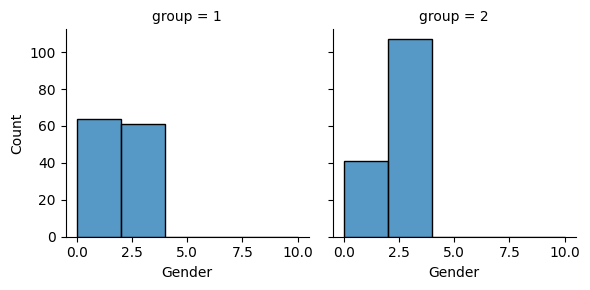

In [4]:
g = sns.FacetGrid(dataM, col="group", margin_titles=True)

g.map_dataframe(sns.histplot, x="Gender", binwidth=2, binrange=(0, 10))

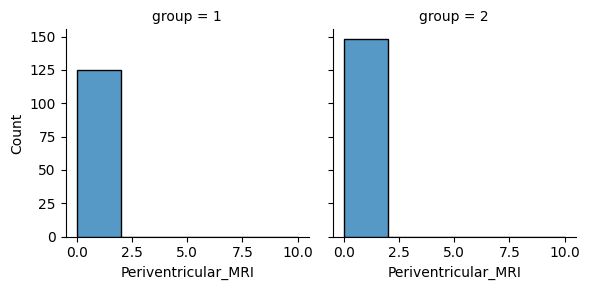

In [5]:
g = sns.FacetGrid(dataM, col="group", margin_titles=True)

g.map_dataframe(sns.histplot, x="Periventricular_MRI", binwidth=2, binrange=(0, 10))

In [6]:
dataM.groupby('group')["Periventricular_MRI"].mean()

group
1         0.8
2    0.256757
Name: Periventricular_MRI, dtype: Float64

In [7]:
dataM.groupby('group')["Infratentorial_MRI"].mean()

group
1       0.504
2    0.114865
Name: Infratentorial_MRI, dtype: Float64

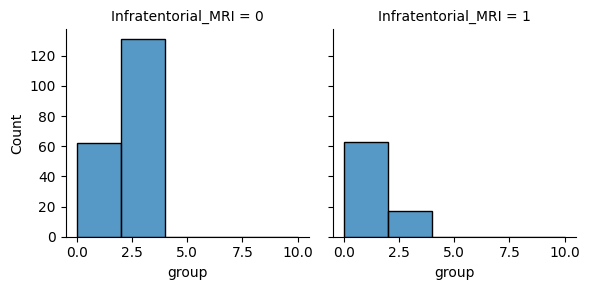

In [8]:
g = sns.FacetGrid(dataM, col="Infratentorial_MRI", margin_titles=True)

g.map_dataframe(sns.histplot, x="group", binwidth=2, binrange=(0, 10))

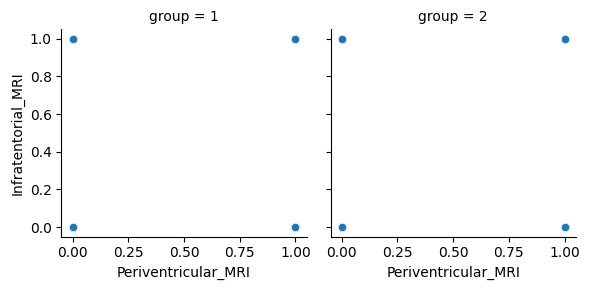

In [9]:
g = sns.FacetGrid(dataM, col="group", margin_titles=True)

g.map_dataframe(sns.scatterplot, x="Periventricular_MRI", y="Infratentorial_MRI")

### Modelo 1 MODIFICANDO indices en initial-edss - random forest

In [10]:
dataM['group'] = dataM['group'].replace(2, 0)

In [11]:
# valores faltantes en initial_edss
indices_faltantes = dataM[dataM['Initial_EDSS'].isnull()].index
num_missing = len(indices_faltantes)
print(num_missing) #cuantos nan hay

148


In [12]:
# Calcular la cantidad de valores a asignar a cada categoría
quarter = num_missing // 4
remainder = num_missing % 4

# Crear una nueva columna para indicar si se imputó un valor
dataM['imputado?'] = 0
dataM.loc[indices_faltantes, 'imputado?'] = 1

# dataM

In [13]:
dataM['Initial_EDSS'].value_counts()

Initial_EDSS
1    87
2    31
3     7
Name: count, dtype: Int64

In [14]:
# # Separar las características y la etiqueta
# # Shuffle Data
# dataM = dataM.sample(frac=1).reset_index(drop=True)

# X = dataM.drop('group', axis=1)
# y = dataM['group']

# X = X.drop('imputado?', axis=1)
# # X = X.drop('Initial_EDSS', axis=1)

# # Replace have of Initial_EDSS without NaNs with NaN

# has_initial = dataM[dataM['Initial_EDSS'].notnull()].index

# # Calcular la cantidad de valores a asignar a cada categoría
# fraction = 3

# quarter = len(has_initial) // fraction
# remainder = len(has_initial) % fraction

# # X["Initial_EDSS_Alt"] = X["Initial_EDSS"]
# X.loc[has_initial[:quarter], 'Initial_EDSS_Alt'] = np.nan

# X = X.drop('Initial_EDSS', axis=1)
# X = X.drop('Initial_EDSS_Alt', axis=1)

In [15]:
# # Dividir los datos en entrenamiento, validación y prueba
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
# X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [16]:
# rf = RandomForestClassifier(random_state=42)
# rf.fit(X_train, y_train)

In [17]:
# importances = rf.feature_importances_

# indices = np.argsort(importances)[::-1]

# fig, ax = plt.subplots()

# ax.barh(range(X_train.shape[1]), importances[indices])
# ax.set_yticks(range(X_train.shape[1]))
# ax.set_yticklabels(X_train.columns[indices])

# plt.show()

In [18]:
# y_pred = rf.predict(X_val)
# # exactitud = accuracy_score(y_val, y_pred)


# fpr, tpr, _ = roc_curve(y_val, y_pred)
# roc_auc = auc(fpr, tpr)

# plt.figure()
# lw = 2
# plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')

# plt.title(f'Receiver Operating Characteristic - {roc_auc:.2f}')

In [19]:
# from sklearn.metrics import confusion_matrix
# cm = confusion_matrix(y_val, y_pred)

# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# plt.show()


## exactitud de los modelos dependiendo de cuanto porciento se le quita a initial

In [20]:
def shuffle_and_convert_nan(dataM, porcentaje):
  dataM = dataM.sample(frac=1)
  filas_con_initial = dataM[dataM['Initial_EDSS'].notnull()].index
  cant_initial_Enporcentaje = int(len(filas_con_initial) * porcentaje / 100)

  #convierte 
  convertidos = np.random.choice(filas_con_initial, size=cant_initial_Enporcentaje, replace=False)
  dataM.loc[convertidos, 'Initial_EDSS'] = np.nan
  X = dataM.drop('group', axis=1)
  y = dataM['group']
  return X, y
  

In [21]:
porcentajes = range(0, 101, 10) # de 0% a 100% con intervalos de 10
auc_scores = []
for porcentaje in porcentajes:
    X, y = shuffle_and_convert_nan(dataM.copy(), porcentaje)

    #train  
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

    #test
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    roc_auc = roc_auc_score(y_val, y_pred)
    auc_scores.append(roc_auc)


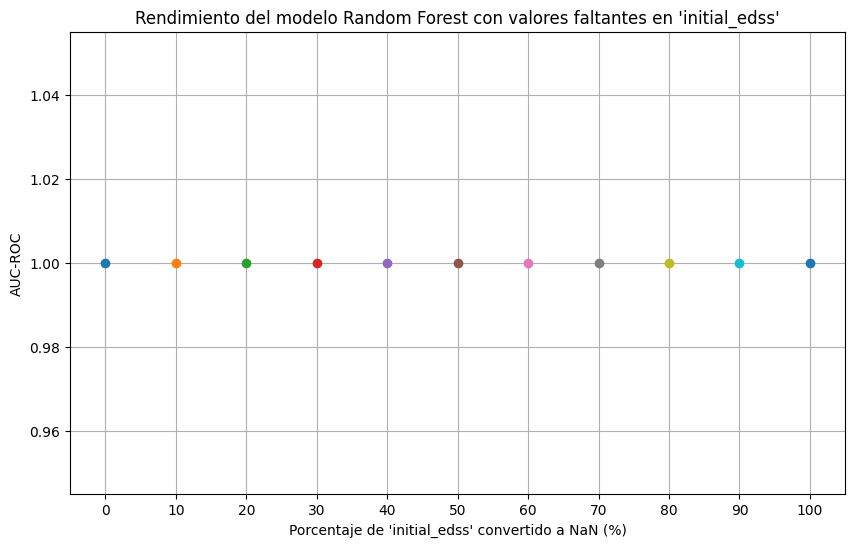

In [22]:
plt.figure(figsize=(10, 6))
for i, porcentaje in enumerate(porcentajes):
    plt.plot(porcentaje, auc_scores[i], 'o-')
plt.xlabel("Porcentaje de 'initial_edss' convertido a NaN (%)")
plt.ylabel("AUC-ROC")
plt.title("Rendimiento del modelo Random Forest con valores faltantes en 'initial_edss'")
plt.xticks(porcentajes)
plt.grid(True)
plt.show()
